In [1]:
import os
import pandas as pd
import numpy as np
from osgeo import gdal
import climate_econometrics_toolkit.user_api as api
from exactextract import exact_extract
import geopandas as gpd
import math
import random
import subprocess
import matplotlib.pyplot as plt

/home/hayden-freedman/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/hayden-freedman/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
cet_home = os.getenv("CETHOME")
reproduction_dir = cet_home + "/ortiz-bobea-reproduction/"
gcm_data_dir = f"{reproduction_dir}/processed_gcm_data/"

# Build model with CET

In [3]:
api.load_dataset_from_file("../data/ortiz_bobea_data.csv")
api.set_target_variable("tfp")
api.set_time_column("year")
api.set_panel_column("ISO3")

In [4]:
# construct model
api.add_covariates(["tmean", "prcp"])
api.add_fixed_effects(["year","ISO3"])
api.add_transformation("tfp", ["ln", "fd"])
api.add_transformation("tmean", "fd")
api.add_transformation("tmean", ["sq", "fd"])
api.add_transformation("prcp", "fd")
api.add_transformation("prcp", ["sq", "fd"])
api.remove_covariates(["tmean","prcp"])

In [5]:
api.view_current_model()

target_var : fd(ln(tfp))
covariates : ['fd(tmean)', 'fd(sq(tmean))', 'fd(prcp)', 'fd(sq(prcp))']
fixed_effects : ['year', 'ISO3']
random_effects : None
time_trends : []
time_column : year
panel_column : ISO3
out_sample_mse : nan
out_sample_mse_reduction : nan
out_sample_pred_int_cov : nan
r2 : nan
rmse : nan
model_id : None


In [6]:
model_id = api.evaluate_model()

/home/hayden-freedman/.local/lib/python3.10/site-packages/pyfixest/estimation/demean_.py:229: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  n_threads = nb.get_num_threads()


                      Coef.      Std.Err.             t         P>|t|  \
const         -1.734723e-18  8.626523e-04 -2.010919e-15  1.000000e+00   
fd(tmean)     -7.849953e-03  4.701395e-03 -1.669707e+00  9.501175e-02   
fd(sq(tmean)) -2.588614e-05  1.242403e-04 -2.083554e-01  8.349561e-01   
fd(prcp)       1.812216e-04  3.369585e-05  5.378159e+00  7.712256e-08   
fd(sq(prcp))  -1.844869e-07  4.121845e-08 -4.475832e+00  7.704227e-06   

                     [0.025        0.975]  
const         -1.690993e-03  1.690993e-03  
fd(tmean)     -1.706575e-02  1.365840e-03  
fd(sq(tmean)) -2.694251e-04  2.176528e-04  
fd(prcp)       1.151702e-04  2.472731e-04  
fd(sq(prcp))  -2.652843e-07 -1.036894e-07  
Model ID: 1740764196.2299063


In [8]:
api.get_model_by_id("1740764196.2299063").print()

target_var : fd(ln(tfp))
covariates : ['fd(tmean)', 'fd(sq(tmean))', 'fd(prcp)', 'fd(sq(prcp))']
fixed_effects : ['year', 'ISO3']
random_effects : None
time_trends : []
time_column : year
panel_column : ISO3
out_sample_mse : 0.006762246791114467
out_sample_mse_reduction : 0.009887077539116084
out_sample_pred_int_cov : 0.9494639992633622
r2 : 0.011
rmse : 0.08223288144723172
model_id : 1740764196.2299063


# Bootstrap model for coefficient samples

In [7]:
api.run_block_bootstrap(api.get_model_by_id(model_id), num_samples=1000)

Running bootstrap...this may take awhile


100% (1000 of 1000) |####################| Elapsed Time: 1:07:02 Time:  1:07:023630


# Make predictions on GCM data

In [9]:
model = api.get_model_by_id(model_id)
for gcm in os.listdir(gcm_data_dir):
    if os.path.isdir(gcm_data_dir + "/" + gcm):
        gcm_data = pd.read_csv(gcm_data_dir + "/" + gcm + "/clim_diff.csv")
        predictions = api.predict_out_of_sample(model, gcm_data)
        predictions.to_csv(f"{reproduction_dir}/predictions/predictions_{model.model_id}_{gcm}.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/hayden-freedman/climate_econometrics_toolkit/ortiz-bobea-reproduction//processed_gcm_data/'

In [7]:
random.seed(1)

revenue_data = pd.read_csv("../ortiz-bobea-reproduction/revenue_shares.csv")
country_weights = {}
for row in revenue_data.itertuples():
    if row[3] in set(predictions.ISO3):
        country_weights[row[3]] = np.mean([row[5],row[6],row[7],row[8],row[9],row[10]])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

gcm_samples = {}
for prediction_file in os.listdir(f"{reproduction_dir}/predictions/"):
    if prediction_file.endswith(".csv") and str(model.model_id) in prediction_file:
        predictions = pd.read_csv(f"{reproduction_dir}/predictions/{prediction_file}")
        gcm_samples[prediction_file] = api.call_user_prediction_function("cumulative_sum_of_predictions_by_geolocation", [model, predictions, country_weights, [str(val) for val in list(range(0,1000))]])
num_samples = 2000
gcm_sample = random.choices(list(gcm_samples.keys()), k=num_samples)
sample = random.choices(list(range(1000)), k=num_samples)
total_impacts = []
for year in range(0,60):
    year_impacts = []
    for i in range(num_samples):
        year_impacts.append((math.exp(np.array(gcm_samples[gcm_sample[i]])[year][sample[i]])-1)*100)
    total_impacts.append(year_impacts)
interval_90 = np.quantile(total_impacts, [.05, .95])
print(np.mean(total_impacts), interval_90[0], interval_90[1])

-6.2186703811128545 -25.7799081649575 2.7399226702738755


In [8]:
total_impacts_df = pd.DataFrame.from_records(total_impacts)

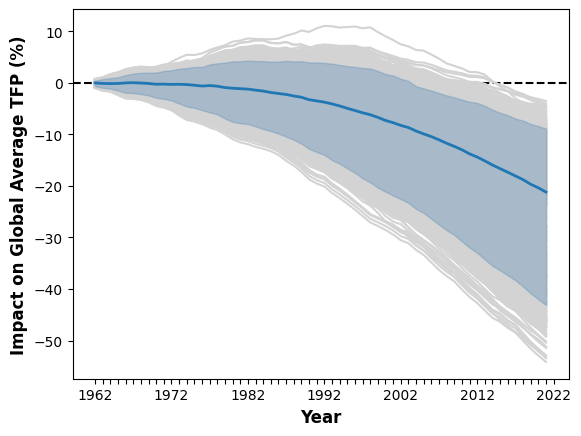

In [42]:
for col in total_impacts_df.columns:
    plt.plot(total_impacts_df[col], color="lightgray", zorder=1)
plt.plot(np.mean(total_impacts_df, axis=1), linewidth=2, zorder=3)
percentile_5 = np.quantile(total_impacts_df, .05, axis=1)
percentile_95 = np.quantile(total_impacts_df, .95, axis=1)
plt.fill_between(list(range(0,60)), percentile_5, percentile_95, color="steelblue", alpha=.3, zorder=2)
plt.axhline(y=0, color="black", linestyle='--', zorder=0)
plt.xlabel("Year", fontweight="bold", size=12)
plt.xticks([i for i in range(0,len(total_impacts_df)+1)],[1962+i if (1960+i) % 10 == 0 else "" for i in range(0,len(total_impacts_df)+1)])
plt.ylabel("Impact on Global Average TFP (%)", fontweight="bold", size=12)
plt.savefig("../figures/ortiz_reproduction.png")